<a href="https://colab.research.google.com/github/mostafa-ja/Transformers/blob/main/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unofficial Walkthrough of Vision Transformer

Hiroto Honda  [homepage](https://hirotomusiker.github.io/)  

<a href="http://colab.research.google.com/github/hirotomusiker/schwert_colab_data_storage/blob/master/notebook/Vision_Transformer_Tutorial.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>  

This notebook provides the simple walkthrough of the Vision Transformer. We hope you will be able to understand how it works by looking at the actual data flow during inference.  

credits:
- Paper: Alexey Dosovitskiy et al., "An Image Is Worth 16x16 Words: Transformers for Image Recognition at Scale", 
https://arxiv.org/abs/2010.11929
- Model Implementation: this notebook loads (and is inspired by) Ross Wightman (@wightmanr)'s amazing module: https://github.com/rwightman/pytorch-image-models/tree/master/timm . For the detailed codes, please refer to the repo.
- The copyright of figures and demo images belongs to Hiroto Honda.



[Getting Started with PyTorch Image Models (timm)](https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055)

[Intro explanation the vision transformers](https://learnopencv.com/the-future-of-image-recognition-is-here-pytorch-vision-transformer/)

# Preparation

In [1]:
%%capture
!pip install timm==0.4.5

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import timm

In [3]:
timm.list_models('vit*')

['vit_base_patch16_224',
 'vit_base_patch16_224_in21k',
 'vit_base_patch16_384',
 'vit_base_patch32_224',
 'vit_base_patch32_224_in21k',
 'vit_base_patch32_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50_224_in21k',
 'vit_base_resnet50_384',
 'vit_base_resnet50d_224',
 'vit_deit_base_distilled_patch16_224',
 'vit_deit_base_distilled_patch16_384',
 'vit_deit_base_patch16_224',
 'vit_deit_base_patch16_384',
 'vit_deit_small_distilled_patch16_224',
 'vit_deit_small_patch16_224',
 'vit_deit_tiny_distilled_patch16_224',
 'vit_deit_tiny_patch16_224',
 'vit_huge_patch14_224_in21k',
 'vit_large_patch16_224',
 'vit_large_patch16_224_in21k',
 'vit_large_patch16_384',
 'vit_large_patch32_224',
 'vit_large_patch32_224_in21k',
 'vit_large_patch32_384',
 'vit_small_patch16_224',
 'vit_small_resnet26d_224',
 'vit_small_resnet50d_s3_224']

In [4]:
model_name = 'vit_base_patch16_224'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device = ',device)
model = timm.create_model(model_name=model_name,pretrained=True).to(device)

device =  cuda


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth


In [5]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (pre_logits): Identity(

In [6]:
image_size = (224,224)
norm_mean = (0.5,0.5,0.5)
norm_std = (0.5,0.5,0.5)
transforms = [T.Resize(image_size),
              T.ToTensor(),
              T.Normalize(norm_mean,norm_std)
              ]
transforms = T.Compose(transforms)

In [7]:
%%capture
# ImageNet Labels
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))



```
values = ["a", "b"]
enum_instance = enumerate(values)
enum_instance
<enumerate at 0x7fe75d728180>
next(enum_instance)
(0, 'a')
>>> next(enum_instance)
(1, 'b')
```



In [8]:
a = enumerate(open('ilsvrc2012_wordnet_lemmas.txt'))
print(next(a))
print(next(a))

(0, 'tench, Tinca_tinca\n')
(1, 'goldfish, Carassius_auratus\n')


In [9]:
dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

{0: 'tench, Tinca_tinca\n',
 1: 'goldfish, Carassius_auratus\n',
 2: 'great_white_shark, white_shark, man-eater, man-eating_shark, Carcharodon_carcharias\n',
 3: 'tiger_shark, Galeocerdo_cuvieri\n',
 4: 'hammerhead, hammerhead_shark\n',
 5: 'electric_ray, crampfish, numbfish, torpedo\n',
 6: 'stingray\n',
 7: 'cock\n',
 8: 'hen\n',
 9: 'ostrich, Struthio_camelus\n',
 10: 'brambling, Fringilla_montifringilla\n',
 11: 'goldfinch, Carduelis_carduelis\n',
 12: 'house_finch, linnet, Carpodacus_mexicanus\n',
 13: 'junco, snowbird\n',
 14: 'indigo_bunting, indigo_finch, indigo_bird, Passerina_cyanea\n',
 15: 'robin, American_robin, Turdus_migratorius\n',
 16: 'bulbul\n',
 17: 'jay\n',
 18: 'magpie\n',
 19: 'chickadee\n',
 20: 'water_ouzel, dipper\n',
 21: 'kite\n',
 22: 'bald_eagle, American_eagle, Haliaeetus_leucocephalus\n',
 23: 'vulture\n',
 24: 'great_grey_owl, great_gray_owl, Strix_nebulosa\n',
 25: 'European_fire_salamander, Salamandra_salamandra\n',
 26: 'common_newt, Triturus_vulgari

In [10]:
# Demo Image
!wget https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/santorini.png?raw=true -O santorini.png
img = PIL.Image.open('santorini.png')
img_tensor = transforms(img).unsqueeze(0).to(device)

--2023-04-03 17:03:42--  https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/santorini.png?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/hirotomusiker/schwert_colab_data_storage/raw/master/images/vit_demo/santorini.png [following]
--2023-04-03 17:03:42--  https://github.com/hirotomusiker/schwert_colab_data_storage/raw/master/images/vit_demo/santorini.png
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hirotomusiker/schwert_colab_data_storage/master/images/vit_demo/santorini.png [following]
--2023-04-03 17:03:42--  https://raw.githubusercontent.com/hirotomusiker/schwert_colab_data_storage/master/images/vit_demo/santorini.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.10

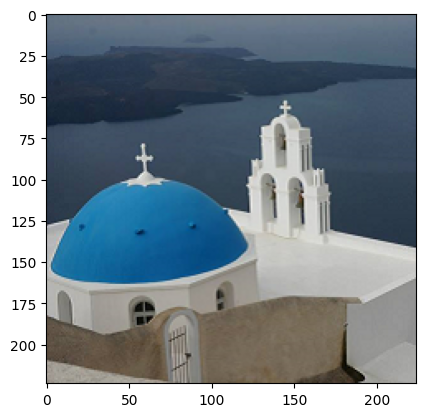

In [11]:
plt.imshow(img)

In [12]:
img_tensor.shape

torch.Size([1, 3, 224, 224])

In [13]:
output = model(img_tensor)
output

tensor([[-5.5439e-01, -3.2103e-01,  3.2367e-02,  2.7764e-02,  1.8016e-01,
         -1.1188e-01,  1.1895e-01,  4.6032e-01,  3.2791e-02,  1.3457e-01,
         -1.6457e+00, -8.1175e-01, -1.0151e+00, -1.3923e+00, -8.6404e-01,
         -9.7353e-01, -7.1769e-01, -2.6630e-01, -2.3284e-01, -1.2080e+00,
         -4.6395e-01, -3.9983e-01, -9.5112e-01,  4.8080e-01,  3.5940e-02,
         -7.3714e-01, -2.1801e-01, -5.6651e-01, -5.4849e-01, -8.4037e-01,
         -3.9684e-01, -4.0876e-01, -2.8523e-01, -1.7682e-01,  9.5630e-01,
         -6.5137e-01, -3.1483e-01, -6.0974e-01,  1.9802e-01, -3.9342e-01,
         -1.0133e+00, -7.2034e-01, -7.5755e-01, -1.2794e+00, -4.6747e-01,
         -2.3635e-01, -6.3173e-01, -7.8328e-01, -1.9773e-01, -1.3142e+00,
         -1.0600e+00, -6.4331e-01, -3.7046e-01, -5.5916e-01, -6.6888e-01,
         -1.0690e+00, -5.2214e-01, -2.7315e-01, -5.4809e-02, -1.0998e+00,
          7.3668e-01, -3.5250e-01, -3.9608e-01, -8.1209e-01, -4.4794e-01,
         -3.7902e-01, -2.4889e-01, -6.

In [14]:
torch.argmax(output)

tensor(538, device='cuda:0')

In [15]:
imagenet_labels[int(torch.argmax(output))]

'dome\n'

# Dig into Vision Transformer

Let's look at the details of the Vision Transformer!


<img src='https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/vit_input.png?raw=true'>

Figure 1. Vision Transformer inference pipeline.  
1. Split Image into Patches  
The input image is split into 14 x 14 vectors with dimension of 768 by Conv2d (k=16x16) with stride=(16, 16). 
2. Add Position Embeddings  
Learnable position embedding vectors are added to the patch embedding vectors and fed to the transformer encoder. 
3. Transformer Encoder  
The embedding vectors are encoded by the transformer encoder. The dimension of input and output vectors are the same. Details of the encoder are depicted in Fig. 2.
4. MLP (Classification) Head  
The 0th output from the encoder is fed to the MLP head for classification to output the final classification results.


# 1. Split Image into Patches

The input image is split into N patches (N = 14 x 14 for ViT-Base)
and converted to D=768 embedding vectors by learnable 2D convolution:
```
Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
```

we keep all 3D, dont mix them in conv2d

(3,224,224) = 14*14 (3,16,16) = 196 (3,16,16) = 196 (768) = (1,196,768)

In [16]:
patches = model.patch_embed(img_tensor)
print('img_tensor ',img_tensor.shape)
print('patches ',patches.shape)

img_tensor  torch.Size([1, 3, 224, 224])
patches  torch.Size([1, 196, 768])


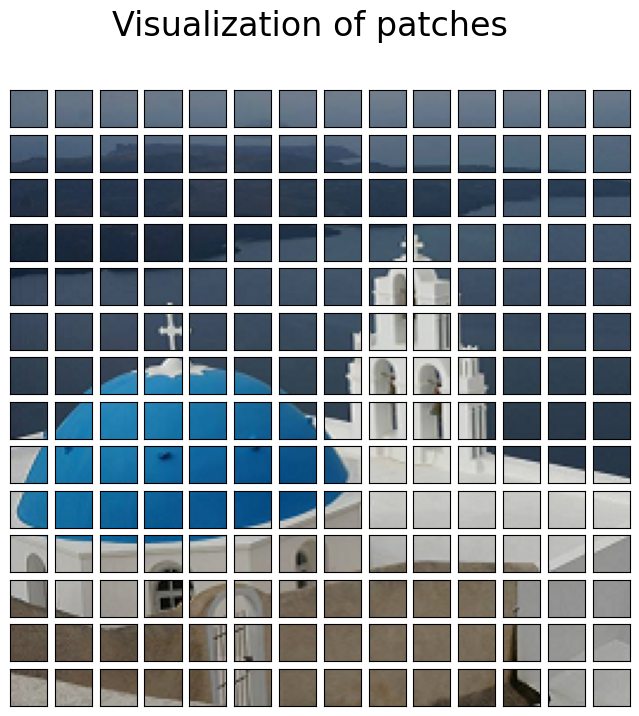

In [17]:
# This is NOT a part of the pipeline.
# Actually the image is divided into patch embeddings by Conv2d 
# with stride=(16, 16) shown above.
fig = plt.figure(figsize=(8,8))
fig.suptitle ('Visualization of patches',fontsize=24)
img = np.asarray(img)
for i in range(196):
  x = i % 14
  y = i // 14
  patch = img[16*y:16*(y+1), 16*x:16*(x+1)]
  ax = fig.add_subplot(14,14,i+1)
  ax.axes.get_xaxis().set_visible(False)
  ax.axes.get_yaxis().set_visible(False)
  ax.imshow(patch)


# 2. Add Position Embeddings
To make patches position-aware, learnable 'position embedding' vectors are added to the patch embedding vectors. The position embedding vectors learn distance within the image thus neighboring ones have high similarity.

### Visualization of position embeddings

**torch.nn.CosineSimilarity(dim=1, eps=1e-08)**

Returns cosine similarity between 

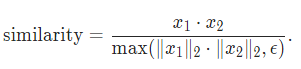
​

Parameters:
dim (int, optional) – Dimension where cosine similarity is computed. Default: 1

eps (float, optional) – Small value to avoid division by zero. Default: 1e-8



```
>>> input1 = torch.randn(100, 128)
>>> input2 = torch.randn(100, 128)
>>> cos = nn.CosineSimilarity(dim=1, eps=1e-6)
>>> output = cos(input1, input2)
```



In [18]:
pos_embed = model.pos_embed
print(pos_embed.shape)

torch.Size([1, 197, 768])


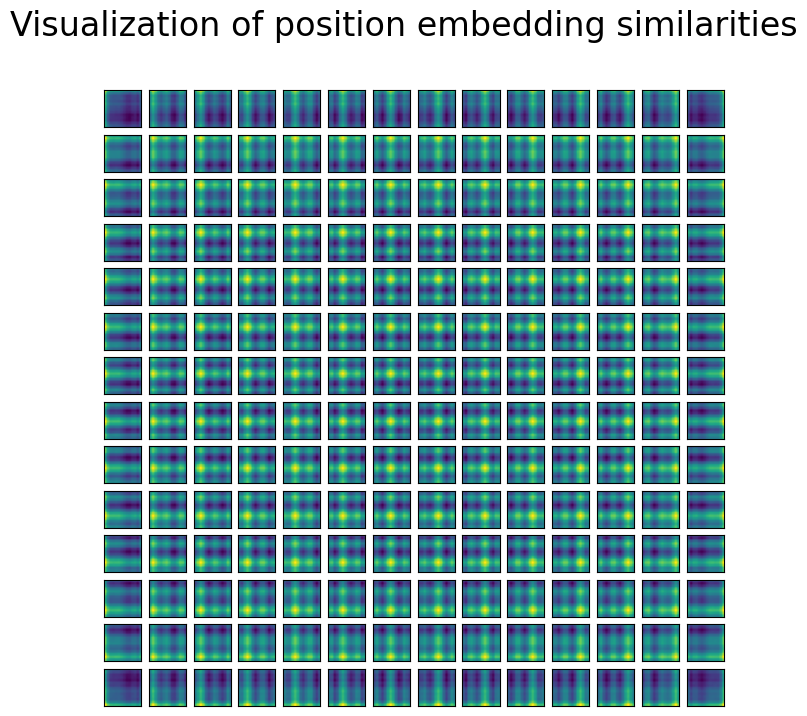

In [19]:
# Visualize position embedding similarities.
# One cell shows cos similarity between an embedding and all the other embeddings.


cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of position embedding similarities", fontsize=24)
for i in range(1, pos_embed.shape[1]):
    sim = cos(pos_embed[0, i:i+1], pos_embed[0, 1:])
    sim = sim.reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(14, 14, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

### Make Transformer Input
A learnable class token is prepended to the patch embedding vectors as the 0th vector.  
197 (1 + 14 x 14) learnable position embedding vectors are added to the patch embedding vectors.

In [20]:
transformer_input = torch.cat((model.cls_token, patches), dim=1) + pos_embed
print("Transformer input: ", transformer_input.shape)

Transformer input:  torch.Size([1, 197, 768])


# 3. Transformer Encoder
<img src='https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/transformer_encoder.png?raw=true'>

Figure 2. Detailed schematic of Transformer Encoder. 
- N (=197) embedded vectors are fed to the L (=12) series encoders. 
- The vectors are divided into query, key and value after expanded by an fc layer. 
- q, k and v are further divided into H (=12) and fed to the parallel attention heads. 
- Outputs from attention heads are concatenated to form the vectors whose shape is the same as the encoder input.
- The vectors go through an fc, a layer norm and an MLP block that has two fc layers.

The Vision Transformer employs the Transformer Encoder that was proposed in the [attention is all you need paper](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf). 

Implementation Reference: 

- [tensorflow implementation](https://github.com/google-research/vision_transformer/blob/502746cb287a107f9911c061f9d9c2c0159c81cc/vit_jax/models.py#L62-L146)
- [pytorch implementation (timm)](https://github.com/rwightman/pytorch-image-models/blob/198f6ea0f3dae13f041f3ea5880dd79089b60d61/timm/models/vision_transformer.py#L79-L143)


### Series Transformer Encoders

In [21]:
# N (=197) embedded vectors are fed to the L (=12) series encoders.
# which means 12 a same encoder block(transformer encoder in the pic) back to back 
model.blocks[0] #first block , the rest exactly are equall to this one
#(qkv):Linear(in_features=768, out_features=2304, bias=True) means Linear(in_features=768, out_features=2304, bias=True)* 3 for k,q,v (2304=3*768)

Block(
  (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (attn): Attention(
    (qkv): Linear(in_features=768, out_features=2304, bias=True)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (proj): Linear(in_features=768, out_features=768, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (drop_path): Identity()
  (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=768, out_features=3072, bias=True)
    (act): GELU(approximate='none')
    (fc2): Linear(in_features=3072, out_features=768, bias=True)
    (drop): Dropout(p=0.0, inplace=False)
  )
)

In [22]:
print("Input tensor to Transformer (z0): ", transformer_input.shape)
x = transformer_input.clone() # Returns a copy of input
for i, blk in enumerate(model.blocks):
    print("Entering the Transformer Encoder {}".format(i))
    x = blk(x)
x = model.norm(x) #torch.Size([1, 197, 768])
transformer_output = x[:, 0] #torch.Size([1, 768]) first output
print("Output vector from Transformer (z12-0):", transformer_output.shape)

Input tensor to Transformer (z0):  torch.Size([1, 197, 768])
Entering the Transformer Encoder 0
Entering the Transformer Encoder 1
Entering the Transformer Encoder 2
Entering the Transformer Encoder 3
Entering the Transformer Encoder 4
Entering the Transformer Encoder 5
Entering the Transformer Encoder 6
Entering the Transformer Encoder 7
Entering the Transformer Encoder 8
Entering the Transformer Encoder 9
Entering the Transformer Encoder 10
Entering the Transformer Encoder 11
Output vector from Transformer (z12-0): torch.Size([1, 768])


## How Attention Works

In this part, we are going to see what the actual attention looks like.

In [23]:
print("Transformer Multi-head Attention block:")
attention = model.blocks[0].attn
print(attention)
print("input of the transformer encoder:", transformer_input.shape)

Transformer Multi-head Attention block:
Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)
input of the transformer encoder: torch.Size([1, 197, 768])




```
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
```





```
dim = 768
num_heads = 12
head_dim = dim // num_heads
scale = head_dim ** -0.5

x = transformer_input

B, N, C = x.shape
qkv = attention.qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

attn = (q @ k.transpose(-2, -1)) * scale
print(attn.shape)
#attn = attn.softmax(dim=-1)
print(attn.shape)
```



In [29]:
# fc layer to expand the dimension (*3 for q,k,v)
transformer_input_expanded = attention.qkv(transformer_input)[0] # to convert (1,197,2304) to (197,2304)
print("expanded to: ", transformer_input_expanded.shape)

expanded to:  torch.Size([197, 2304])


The permute function can do the same as the transpose function. However, the permute function is more general and allows for additional operations.

In [30]:
# Split qkv into mulitple q, k, and v vectors for multi-head attantion
qkv = transformer_input_expanded.reshape(197, 3, 12, 64)  # (N=197, (qkv), H=12, D/H=64)
print("split qkv : ", qkv.shape)
q = qkv[:, 0].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
k = qkv[:, 1].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
kT = k.permute(0, 2, 1)  # (H=12, D/H=64, N=197)
print("q : ", q.shape)
print("transposed ks: ", kT.shape)

split qkv :  torch.Size([197, 3, 12, 64])
q :  torch.Size([12, 197, 64])
transposed ks:  torch.Size([12, 64, 197])


attention matrix:  torch.Size([12, 197, 197])


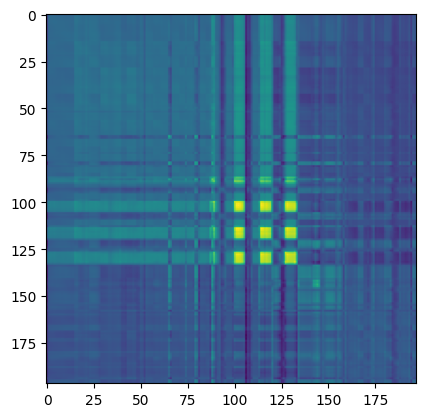

In [31]:
attention_matrix = q @ kT 
print("attention matrix: ", attention_matrix.shape)
plt.imshow(attention_matrix[3].detach().cpu().numpy())

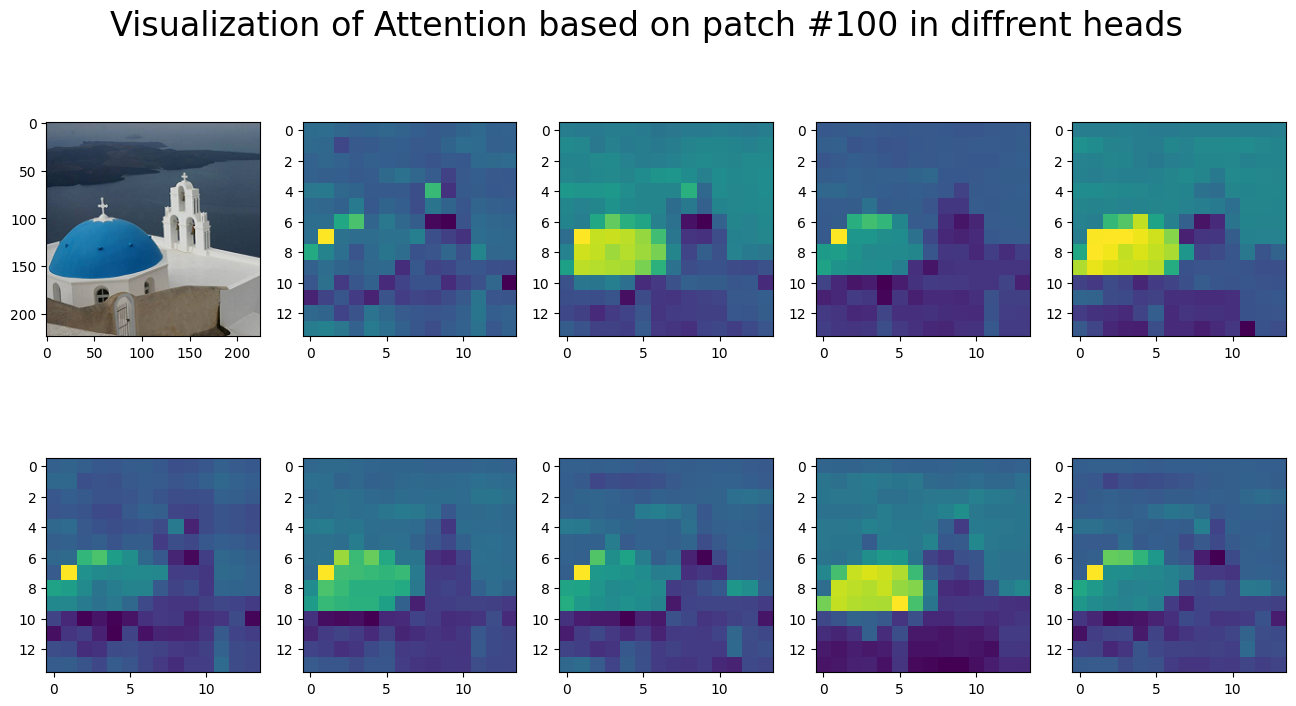

In [49]:
# Visualize attention matrix
# shows , in 14by14 patches ,where we have more attention
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Visualization of Attention based on patch #100 in diffrent heads", fontsize=24)
img = np.asarray(img)
ax = fig.add_subplot(2, 5, 1)
ax.imshow(img)
for i in range(9):  # visualize the 100th rows of attention matrices in the 0-7th heads
    attn_heatmap = attention_matrix[i, 100, 1:].reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(2, 5, i+2)
    ax.imshow(attn_heatmap)

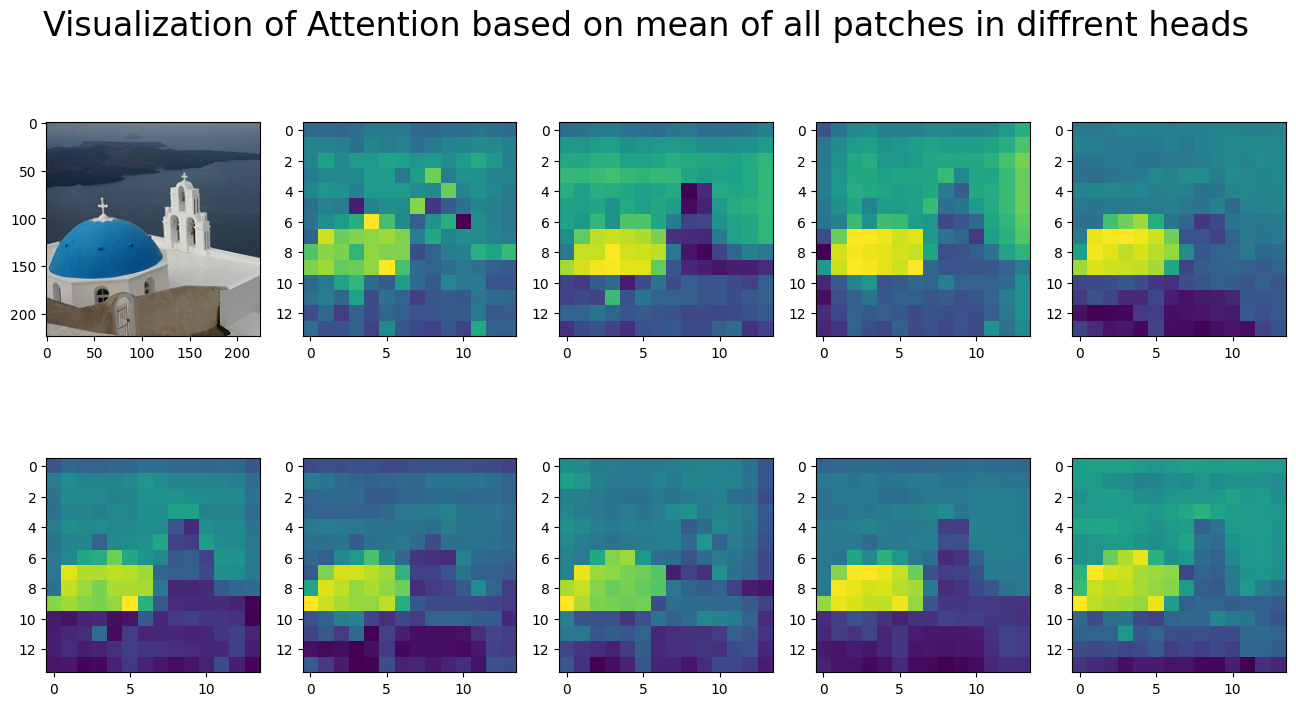

In [50]:
# Visualize attention matrix
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Visualization of Attention based on mean of all patches in diffrent heads", fontsize=24)
img = np.asarray(img)
ax = fig.add_subplot(2, 5, 1)
ax.imshow(img)
for i in range(9):  # visualize the 100th rows of attention matrices in the 0-7th heads
    attn_heatmap = torch.mean(attention_matrix[i, 1:, 1:],dim=1).reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(2, 5, i+2)
    ax.imshow(attn_heatmap)

# 4. MLP (Classification) Head
The 0-th output vector from the transformer output vectors (corresponding to the class token input) is fed to the MLP head.  
The 1000-dimension classification result is the output of the whole pipeline.

In [52]:
transformer_output.shape

torch.Size([1, 768])

In [51]:
model.head

Linear(in_features=768, out_features=1000, bias=True)

Classification head:  Linear(in_features=768, out_features=1000, bias=True)
Inference result : id = 538, label name = dome



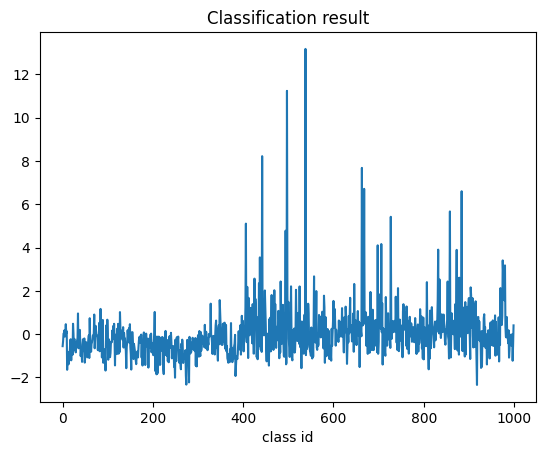

In [54]:
print("Classification head: ", model.head)
result = model.head(transformer_output)
result_label_id = int(torch.argmax(result))
plt.plot(result.detach().cpu().numpy()[0])
plt.title("Classification result")
plt.xlabel("class id")
print("Inference result : id = {}, label name = {}".format(
    result_label_id, imagenet_labels[result_label_id]))

we are going to check , top results and the reason why we got not just one but many results with high result 

In [69]:
torch.topk(result, 5)

torch.return_types.topk(
values=tensor([[13.1739, 11.2362,  8.2204,  7.6791,  6.7112]], device='cuda:0',
       grad_fn=<TopkBackward0>),
indices=tensor([[538, 497, 442, 663, 668]], device='cuda:0'))

In [70]:
top_results = torch.topk(result, 5)[1].detach().cpu().numpy().squeeze()
top_results

array([538, 497, 442, 663, 668])

In [71]:
for i in top_results:
  print(imagenet_labels[i])

dome

church, church_building

bell_cote, bell_cot

monastery

mosque

